In [98]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random
from matplotlib.lines import Line2D

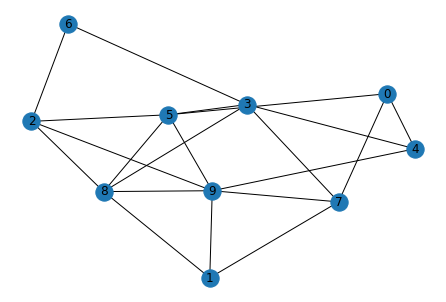

In [130]:
G = nx.erdos_renyi_graph(10, 0.4)
nx.draw_spring(G, with_labels=True)

In [131]:
# initiating all nodes to be susceptible

status_array = dict(G.nodes(data='status', default=0))
nx.set_node_attributes(G, status_array, 'status')
exposed_array = dict(G.nodes(data='exposed_time', default=0))
nx.set_node_attributes(G, exposed_array, 'exposed_time')
infectious_array = dict(G.nodes(data='infectious_time', default=0))
nx.set_node_attributes(G, infectious_array, 'infectious_time')

In [101]:
G.nodes[0]

{'status': 0, 'exposed_time': 0, 'infectious_time': 0}

# Equations for the SEIR model

## $$ \frac{\mathrm{d}S_i}{\mathrm{d}t} = -\beta_iS_i $$
## $$ \frac{\mathrm{d}E_i}{\mathrm{d}t} = \beta_iS_i - \alpha E_i $$
## $$ \frac{\mathrm{d}I_i}{\mathrm{d}t} = \alpha E_i - \gamma I_i $$
## $$ \frac{\mathrm{d}R_i}{\mathrm{d}t} = \gamma I_i $$


## where $$\beta_i = \sum_{j} \beta G_{ij} I_j$$ 

## Here $ \beta $ denotes the probability of transimission. $\alpha$ denotes the rate at which exposed people become infectious. $\gamma$ denotes the recovery rate.

## To implement the above equations in an individual based model, we use the following rules.

* ### A susceptible node $i$ gets infected according to ~ $Binomial(1 - e^{-\beta_i})$.

* ### An exposed node $i$ becomes infectious according to ~ $Binomial(1 - e^{-\alpha t_{exposed}})$, where $t_{exposed}$ is the time since the node got exposed. 

* ### An infectious node $i$ recovers or dies according to ~ $Binomial(1 - e^{-\gamma t_{infectious}})$, where $t_{infectious}$ is the time since the node became infectious.

# <font color='red'>Implementing the SEIR model</font>
### Each node has a ***status*** attribute which denotes the current infection state of that node. The status map is given by : 0 - susceptible (default), 1 - infectious, 2 - exposed, 3 - recovered.
### Each node also has a ***exposed_time*** and a ***infectious_time*** attribute which stores the time since exposed and the time since infectious, respectively. They are non-zero only when a given node is exposed or infectious.

In [127]:
def SEIR_model(iteration_num, graph_list, node_count, params):

    graph = graph_list[-1].copy()
 
    for _ in range(iteration_num):

        temp_node_count = node_count[-1]

        for node in graph:

            # when the current node is susceptible
            if graph.nodes[node]['status']==0:
                num_inf_neighbor = len([v for v in graph.neighbors(node) if graph.nodes[v]['status'] == 1])
                if np.random.random_sample() < 1 - np.exp(-params[1]*num_inf_neighbor):
                    graph.nodes[node]['status'] = 2
                    #graph.nodes[node]['exposed_time'] += 1
                    temp_node_count = [sum(x) for x in zip(temp_node_count, [-1,0,1,0])]

            # when the current node is exposed
            elif graph.nodes[node]['status']==2:
                if np.random.random_sample() < 1 - np.exp(-params[0]*graph.nodes[node]['exposed_time']):
                    graph.nodes[node]['status'] = 1
                    graph.nodes[node]['exposed_time'] = 0
                    #graph.nodes[node]['infectious_time'] += 1
                    temp_node_count = [sum(x) for x in zip(temp_node_count, [0,1,-1,0])]
                else:
                    graph.nodes[node]['exposed_time'] += 1

            # when the current node is infectious        
            elif graph.nodes[node]['status']==1:
                if np.random.random_sample() < 1 - np.exp(-params[2]*graph.nodes[node]['infectious_time']):
                    graph.nodes[node]['status'] = 3
                    graph.nodes[node]['infectious_time'] = 0
                    temp_node_count = [sum(x) for x in zip(temp_node_count, [0,-1,0,1])]
                else:
                    graph.nodes[node]['infectious_time'] += 1

        node_count.append(temp_node_count)
        graph_list.append(graph.copy())

    return graph_list, node_count

In [132]:
infected_nodes = np.random.randint(10, size=(2))
for i in infected_nodes:
    G.nodes[i]['status']=1
infected_nodes

array([6, 8])

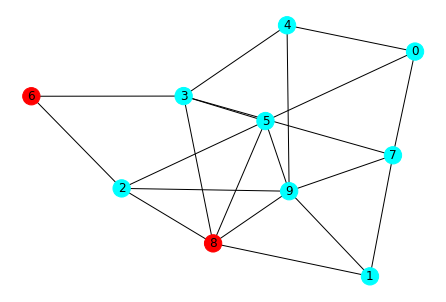

In [133]:
pos = nx.kamada_kawai_layout(G)
color_ref = ['aqua','red','gold','g']
color_map = [color_ref[G.nodes[k]['status']] for k in G]
nx.draw(G, pos, node_color=color_map,with_labels=True)

In [120]:
graph_list = [G.copy()]
init_node_count = [0,0,0,0]
for node in G:
    node_stat = G.nodes[node]['status']
    init_node_count[node_stat] += 1
node_count = [init_node_count]
params = [1/3,0.25,0.25]
g_list, node_count = SEIR_model(20, graph_list, node_count, params)

In [121]:
%matplotlib inline

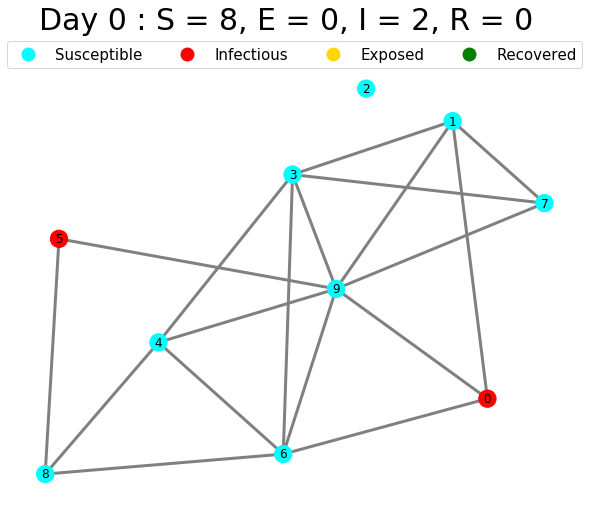

In [122]:
color_ref = ['aqua','red','gold','g']
fig, ax = plt.subplots(figsize=(10,8))
#fig.set_facecolor("#00000F")
# Animation funciton
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Susceptible', markerfacecolor='aqua', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Infectious', markerfacecolor='r', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Exposed', markerfacecolor='gold', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Recovered', markerfacecolor='g', markersize=15)]

def animate(i):
    ax.clear()
    plot_graph = g_list[i].copy()
    color_map = [color_ref[plot_graph.nodes[k]['status']] for k in plot_graph]
    nx.draw(plot_graph, pos, node_color=color_map, with_labels=True, edge_color="gray", width = 3)
    #limits=plt.axis('on') # turns on axis
    fig.suptitle(f"Day {i} : S = {node_count[i][0]}, E = {node_count[i][2]}, I = {node_count[i][1]}, R = {node_count[i][3]}", fontsize=30)
    ax.legend(handles=legend_elements, loc="upper center",
          bbox_to_anchor=(0.5, 1.07), ncol=4, fontsize = 15)
    
    
anim = animation.FuncAnimation(fig, animate, frames=20, interval=1000, repeat=True)
                     
HTML(anim.to_html5_video())

In [126]:
g_list[7].nodes[4]['exposed_time']

0

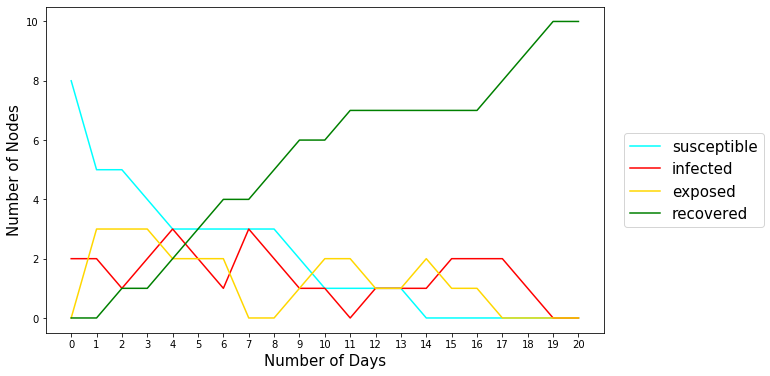

In [97]:
plt.figure(figsize=(10,6))
plt.plot(range(0,len(node_count)),[v[0] for v in node_count], label='susceptible', color = 'aqua')
plt.plot(range(0,len(node_count)),[v[1] for v in node_count], label='infected', color = 'red')
plt.plot(range(0,len(node_count)),[v[2] for v in node_count], label='exposed', color = 'gold')
plt.plot(range(0,len(node_count)),[v[3] for v in node_count], label='recovered', color = 'green')
plt.xlabel('Number of Days', fontsize = 15)
plt.ylabel('Number of Nodes', fontsize = 15)
plt.xticks(range(0,len(node_count)))
plt.legend(loc="lower right", bbox_to_anchor=(1.3, 0.3), fontsize = 15)

In [134]:
np.shape(range(0,len(node_count)))

(21,)

In [ ]:
np.shape(range(node_count))

In [137]:
for node in G:
    print(node)

0
1
2
3
4
5
6
7
8
9


In [138]:
for node in list(range(10)):
    print(node)

0
1
2
3
4
5
6
7
8
9
